# Exploratory Yelp Data Analysis and Visualization 

## Group: 

**Notes: this cell is reserved as a temperary Table of contents, please put any add-functionalities to this main notebook here**  
Table of contents  
Motivations  
Which cities to crawl (from two resources)  
Explain the Scrapy framework and functions  

## Table of Contents:
* [Project Overview and Motivations](#first-bullet)
   - [Part I: Data Loading and Pre-Processing](#sub1)
   - [Part II: Feature Selection & Engineering](#second-bullet)
    - [Section 2.1: Feature Selection Principle](#sub1)
      - [Features to be dropped](#sub2)
      - [Features to be re-engineered](#sub2)
      - [Features to be kept even there are missing, special imputation needed](#sub2)
    - [Section 2.2: Data Imputation](#sub1)
      - [Imputation using fillna to 0](#sub2)
      - [sklearn Imputation using the mean](#sub2)
    - [Section 2.3: Data Normalization](#sub1)
    - [Section 2.4: Data Spliting](#sub1)
   - [Part III: Classification Model Building](#third-bullet)
    - [Section 1: Selection of the Methodology](#sub1)
    - [Section 2: Method Implementation and Pipeline](#sub1)
   - [Part IV: Classification Model Optimization](#fourth-bullet)
   - [Part V: Extracting Feature Importance](#fifth-bullet)
   - [Part VI: Multi-class exploration](#fifth-bullet)
* [Comment on Future work](#future-work)

## Section 0: Project Overview and Motivations
The 

In [1]:
import pandas as pd
import sys
import numpy as np
# from pathlib import Path
from urllib.request import urlopen
import re
import os
import string

import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

# Visualization pkgs
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('ggplot')
import seaborn as sns
from plotnine import *
from wordcloud import WordCloud 
from pyecharts.charts import Pie
from pyecharts import options as opts

sys.path.insert(0, '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')
import pymysql
from bs4 import BeautifulSoup

In [2]:
# helper functions from Codebase 
sys.path.insert(0, '../Codebase/')
from db_utils import YelpDb
#from MissingValue import MissingValue

## Section I: Build Web Crawler 
We used two resources to determine which cities in California  
Resource 1: https://patch.com/california/lajolla/ca-cities-rank-among-best-big-cities-live  
Resource 2: https://en.wikipedia.org/wiki/List_of_largest_California_cities_by_population

In [3]:
# Resource 1:
# open url connection 
link = 'https://patch.com/california/lajolla/ca-cities-rank-among-best-big-cities-live'
html = urlopen(link).read()
soup = BeautifulSoup(html, features="html5lib")

# use class to narrow search, based on observation 
target_level = soup.find('section', {"class": "article-body"})
target_level_2 = target_level.find_all('ol')[1]
target_level_3 = target_level_2.find_all('li')
cali_cities = []
for info in target_level_3:
    cali_cities.append(info.get_text(strip=True))
for i in cali_cities:
    flag = re.findall("[A-Za-z ]", i)
    if flag:
        token = "".join(flag)
        print(token)

San Diego 
San Francisco 
San Jose 
Sacramento 
Riverside 
Los Angeles 
Long Beach 
Anaheim 
Bakersfield 
Oakland 
Santa Ana 
Fresno 


In [4]:
# Resource 2:
link = 'https://en.wikipedia.org/wiki/List_of_largest_California_cities_by_population'
html = urlopen(link).read()

soup = BeautifulSoup(html, features="html")
cities = []
table = soup.find('table', {"class": "wikitable sortable"})
rows = table.find_all("tr")
for row in rows[1:]:
    city = row.find_all("td")[1].get_text(strip=True)
    cities.append(city)
print(cities[:12])

['Los Angeles', 'San Diego', 'San Jose', 'San Francisco', 'Fresno', 'Sacramento', 'Long Beach', 'Oakland', 'Bakersfield', 'Anaheim', 'Santa Ana', 'Riverside']


From the two resources, we 

## Section II: Read data from sql server into pandas

**Note**: this method is only for reading dumped .sql file that already live in local server; for usage of that .sql file on another machine, you need to refer this:  
https://blog.csdn.net/spartanfuk/article/details/81368465?depth_1-utm_source=distribute.pc_relevant.none-task

**Workflow**: 
1. .sql files to DF.
2. DFs to csv.
3. csv. to EDA
4. delete csv.


In [5]:
# playground


### Part I: Show all tables in two databases 

In [6]:
# build DB connections
yelp_db_group = YelpDb("test")

                         
yelp_db_group.import_sql(os.path.abspath("../Database/yelp_dbs/yelp_1_6.sql")  # cities 1-6
yelp_db_group.import_sql(os.path.abspath("../Database/yelp_dbs/yelp_7_12.sql") # cities 7-12

sql_tabs = "show TABLES;"
yelp_db_group.execute(sql_tabs)
yelp_db_group.fetch_all()

(('yelp_anaheim',),
 ('yelp_bakersfield',),
 ('yelp_fresno',),
 ('yelp_long_beach',),
 ('yelp_los_angeles',),
 ('yelp_oakland',),
 ('yelp_riverside',),
 ('yelp_sacramento',),
 ('yelp_san_diego',),
 ('yelp_san_francisco',),
 ('yelp_san_jose',),
 ('yelp_santa_ana',))

### Part II: Read all crawled databases tables into DataFrame 

In [7]:
# Table 1
yelp_df_la = yelp_db_group.db_to_df("yelp_los_angeles")
print(f'Yelp data for Los Angeles: number of rows (restaurants) = {yelp_df_la.shape[0]}')
print(f'number of columns (features) = {yelp_df_la.shape[1]}')
# yelp_df_la.head(3)

Yelp data for Los Angeles: number of rows (restaurants) = 990
number of columns (features) = 22


In [8]:
# Table 2
yelp_df_sd = yelp_db_group.db_to_df("yelp_san_diego")
print(f'Yelp data for San Diego: number of rows (restaurants) = {yelp_df_sd.shape[0]}')
print(f'number of columns (features) = {yelp_df_sd.shape[1]}')
# yelp_df_sd.head(3)

Yelp data for San Diego: number of rows (restaurants) = 990
number of columns (features) = 22


In [9]:
# Table 3
yelp_df_sj = yelp_db_group.db_to_df("yelp_san_jose")
print(f'Yelp data for San Jose: number of rows (restaurants) = {yelp_df_sj.shape[0]}')
print(f'number of columns (features) = {yelp_df_sj.shape[1]}')
# yelp_df_sj.head(3)

Yelp data for San Jose: number of rows (restaurants) = 990
number of columns (features) = 22


In [10]:
# Table 4
yelp_df_sf = yelp_db_group.db_to_df("yelp_san_francisco")
print(f'Yelp data for San Francisco: number of rows (restaurants) = {yelp_df_sf.shape[0]}')
print(f'number of columns (features) = {yelp_df_sf.shape[1]}')
# yelp_df_sf.head(3)

Yelp data for San Francisco: number of rows (restaurants) = 990
number of columns (features) = 22


In [11]:
# Table 5
yelp_df_fr = yelp_db_group.db_to_df("yelp_fresno")
print(f'Yelp data for Fresno: number of rows (restaurants) = {yelp_df_fr.shape[0]}')
print(f'number of columns (features) = {yelp_df_fr.shape[1]}')
# yelp_df_fr.head(3)

Yelp data for Fresno: number of rows (restaurants) = 989
number of columns (features) = 22


In [12]:
# Table 6
yelp_df_sc = yelp_db_group.db_to_df("yelp_sacramento")
print(f'Yelp data for Sacramento: number of rows (restaurants) = {yelp_df_sc.shape[0]}')
print(f'number of columns (features) = {yelp_df_sc.shape[1]}')
# yelp_df_sc.head(3)

Yelp data for Sacramento: number of rows (restaurants) = 990
number of columns (features) = 22


In [13]:
# Table 7
yelp_df_lb = yelp_db_group.db_to_df("yelp_Long_Beach")
print(f'Yelp data for Long Beach: number of rows (restaurants) = {yelp_df_lb.shape[0]}')
print(f'number of columns (features) = {yelp_df_lb.shape[1]}')
# yelp_df_lb.head(3)

Yelp data for Long Beach: number of rows (restaurants) = 989
number of columns (features) = 22


In [14]:
# Table 8
yelp_df_ok = yelp_db_group.db_to_df("yelp_Oakland")
print(f'Yelp data for Oakland: number of rows (restaurants) = {yelp_df_ok.shape[0]}')
print(f'number of columns (features) = {yelp_df_ok.shape[1]}')
# yelp_df_ok.head(3)

Yelp data for Oakland: number of rows (restaurants) = 990
number of columns (features) = 22


In [15]:
# Table 9
yelp_df_bf = yelp_db_group.db_to_df("yelp_Bakersfield")
print(f'Yelp data for Bakersfield: number of rows (restaurants) = {yelp_df_bf.shape[0]}')
print(f'number of columns (features) = {yelp_df_bf.shape[1]}')
# yelp_df_bf.head(3)

Yelp data for Bakersfield: number of rows (restaurants) = 989
number of columns (features) = 22


In [16]:
# Table 10
yelp_df_ah = yelp_db_group.db_to_df("yelp_Anaheim")
print(f'Yelp data for Anaheim: number of rows (restaurants) = {yelp_df_ah.shape[0]}')
print(f'number of columns (features) = {yelp_df_ah.shape[1]}')
# yelp_df_ah.head(3)

Yelp data for Anaheim: number of rows (restaurants) = 984
number of columns (features) = 22


In [17]:
# Table 11
yelp_df_sa = yelp_db_group.db_to_df("yelp_Santa_Ana")
print(f'Yelp data for Santa_Ana: number of rows (restaurants) = {yelp_df_sa.shape[0]}')
print(f'number of columns (features) = {yelp_df_sa.shape[1]}')
# yelp_df_sa.head(3)

Yelp data for Santa_Ana: number of rows (restaurants) = 990
number of columns (features) = 22


In [18]:
# Table 12
yelp_df_rs = yelp_db_group.db_to_df("yelp_Riverside")
print(f'Yelp data for Riverside: number of rows (restaurants) = {yelp_df_rs.shape[0]}')
print(f'number of columns (features) = {yelp_df_rs.shape[1]}')
# yelp_df_rs.head(3)

Yelp data for Riverside: number of rows (restaurants) = 988
number of columns (features) = 22


In [19]:
# initial data components plot
city_list = cities[:12]
rstats_list = [yelp_df_la.shape[0], yelp_df_sd.shape[0], yelp_df_sj.shape[0], yelp_df_sf.shape[0],
               yelp_df_fr.shape[0], yelp_df_sc.shape[0], yelp_df_lb.shape[0], yelp_df_ok.shape[0],
               yelp_df_bf.shape[0], yelp_df_ah.shape[0], yelp_df_sa.shape[0], yelp_df_rs.shape[0]]
comp_dict = {"Cities": city_list, "Restaurants_number": rstats_list}
comp_df = pd.DataFrame(data=comp_dict).sort_values("Restaurants_number", ascending=False)

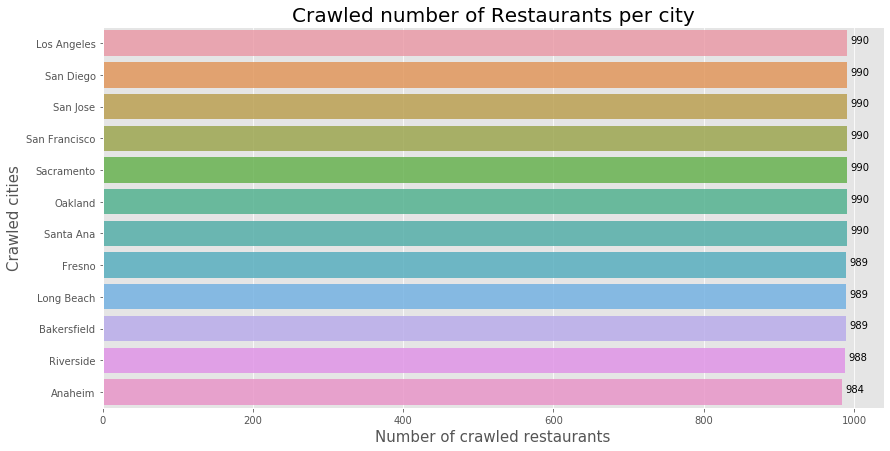

In [20]:
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=comp_df.Restaurants_number, y=comp_df.Cities, alpha=0.8)
plt.title("Crawled number of Restaurants per city", fontsize=20)
plt.ylabel('Crawled cities', fontsize=15)
plt.xlabel('Number of crawled restaurants', fontsize=15)

# adding the text labels
rects = ax.patches 
labels = comp_df.Restaurants_number.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() + 5, height/2 + rect.get_y(), label, ha='left')
plt.show()

**Add comments**

### Data concatenation: Final Form 

In [21]:
# Data concatenation
yelp_df_all = pd.concat([yelp_df_la, yelp_df_sd, yelp_df_sj, yelp_df_sf,
                        yelp_df_fr, yelp_df_sc, yelp_df_lb, yelp_df_ok,
                        yelp_df_bf, yelp_df_ah, yelp_df_sa, yelp_df_rs]).reset_index(drop=True)
print(f'Yelp data for all cities: number of rows (restaurants) = {yelp_df_all.shape[0]}')
print(f'number of columns (features) = {yelp_df_all.shape[1]}')
yelp_df_all.head(3)

Yelp data for all cities: number of rows (restaurants) = 11869
number of columns (features) = 22


,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,Thu,...,Sun,Delivery,Wi_Fi,Takes_Reservations,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out
0,Dave's Hot Chicken,"3462 Wilshire Blvd,Los Angeles,CA,90010",Chicken Shop,$11-30,4.0,82,11:00 am - 1:00 am,11:00 am - 1:00 am,11:00 am - 1:00 am,11:00 am - 1:00 am,...,11:00 am - 1:00 am,No,No,No,"Garage, Street",NULL,Yes,Yes,No,Yes
1,Chef Kang Sul Box,"3881 Wilshire Blvd,Los Angeles,CA,90010","Korean,Gastropubs,Chicken Shop",$11-30,5.0,31,5:00 pm - 2:00 am,5:00 pm - 2:00 am,5:00 pm - 2:00 am,5:00 pm - 2:00 am,...,5:00 pm - 2:00 am,Yes,Free,Yes,"Street, Private Lot, Validated",NULL,Yes,NULL,NULL,Yes
2,CHD,"3377 Wilshire Blvd,Ste 104,Los Angeles,CA,90010",Korean,$11-30,4.5,26,11:00 am - 8:30 pm,11:00 am - 8:30 pm,11:00 am - 8:30 pm,11:00 am - 8:30 pm,...,Closed,No,No,No,"Valet, Validated",Yes,Yes,No,NULL,Yes


### Part III: Data Cleaning

In [22]:
def find_null(item):
    """ fill all missing values or values filled with str "null"
    """
    if not item or (type(item)!=str and np.isnan(item)) or (type(item)==str 
                                                            and item.strip().lower()in ['null', 'none']):
        return "Unknown"
    return item

def exceptions(data):
    """ raise exceptions if any record doesn't match the pattern in function `find_null`
    """
    for column in data.columns:
        for i in range(data.shape[0]):
            try:
                find_null(data[column][i])
            except:
                raise Exception(f"the index {i} in {column}")
    print('No exceptions detected')

In [23]:
def get_open_time(item):
    if re.search(r'open 24', item.lower()):
        return [[0,24]]
    pattern = r'(\d{1,2}):(\d{2}) ([ap]m)' 
    result = []
    for interval in item.split(','):
        tmp = interval.split('-')
        if len(tmp)!=2:
            return item.strip()
        begin, end = tmp
        open_time = [0,0]
        for i,point in enumerate([begin, end]):
            if re.search(pattern, point.strip()):
                time, half = point.strip().split()
                time_digit = time.split(':')
                numeric_hour = int(time_digit[0]) + int(time_digit[1])/60 + 12 * int(half == 'pm')
                open_time[i] = numeric_hour
            else:
                open_time[i] = point
        result.append(open_time)
    return result

In [24]:
# change Parking to binary var
parking_type = ['street', 'lot', 'garage', 'valet']
def get_parking(item):
    result = []
    for park in parking_type:
        if re.search(fr'({park})', item.lower()):
            result.append(1)
        else:
            result.append(0)
    return pd.Series(result)

In [25]:
# drop duplicates data
yelp_df_all = yelp_df_all.drop_duplicates().reset_index()

In [26]:
exceptions(yelp_df_all)
yelp_clean_df = yelp_df_all.applymap(find_null)
yelp_clean_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 
               'Sun']] = yelp_clean_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].applymap(get_open_time)
yelp_clean_df[parking_type] = yelp_clean_df.Parking.apply(get_parking)  # create four new features 
yelp_clean_df.sample(3)

No exceptions detected


,index,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,...,Parking,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out,street,lot,garage,valet
7430,7544,Spice Monkey,"1628 Webster St,Oakland,CA,94612","American (New),Bars",$11-30,3.5,590,Closed,Closed,Closed,...,Street,Yes,Yes,No,Unknown,Yes,1,0,0,0
6252,6252,Fantastic Café,"1180 N Studebaker Rd,Long Beach,CA,90815","Breakfast & Brunch,Diners,Mexican",Under $10,3.5,312,"[[5.0, 23.0]]","[[5.0, 23.0]]","[[5.0, 23.0]]",...,Private Lot,Unknown,Yes,No,No,Yes,0,1,0,0
10092,10423,The Corner,"8961 Adams Ave,Huntington Beach,CA,92646","American (New),Cocktail Bars,Tapas/Small Plates",$11-30,4.0,787,"[[15.0, 23.0]]","[[15.0, 23.0]]","[[24.0, 23.0]]",...,Private Lot,Unknown,Yes,No,Unknown,Yes,0,1,0,0


In [27]:
# drop feature: `Parking`


In [28]:
yelp_clean_df.Price.value_counts()  # no need to do further feature engineering to `Price`

$11-30       6409
Under $10    3399
Unknown      1069
$31-60        439
Above $61      88
Name: Price, dtype: int64

## Section III: Data analysis and visualization

### Part I: Restaurants categorical analysis 

In [29]:
remove = string.punctuation
pattern = r"[{}]".format(remove)
cat_frequency = {}
def regex_split_join(item):
    """ statistics on word frequency by attributes
    """
    try:
        to_be_join = re.split(pattern, item.strip())
    except:
        raise Exception(f'the item --{item} in the line above is not a string')
    for word in to_be_join:
        new_word = word.strip()
        if new_word in cat_frequency:
            cat_frequency[new_word] += 1
        else:
            cat_frequency[new_word] = 1
    return " ".join(to_be_join)

In [30]:
def make_word_cloud(text, d, max_word=30):
    """ generate word cloud by word frequency
    """
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords.words("english"),
        scale=10,
        max_words=max_word,
        max_font_size=40)
    wordcloud = wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure(1,figsize=(15,15))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear") 

In [31]:
# apply word stats 
yelp_clean_df[['Category']].applymap(regex_split_join)  # deep copy
del cat_frequency["Unknown"]  # drop the "Unknown" case
if "" in cat_frequency:
    del cat_frequency[""]  # drop the "" case

There are 297 different word categories to describe restaurants in Yelp


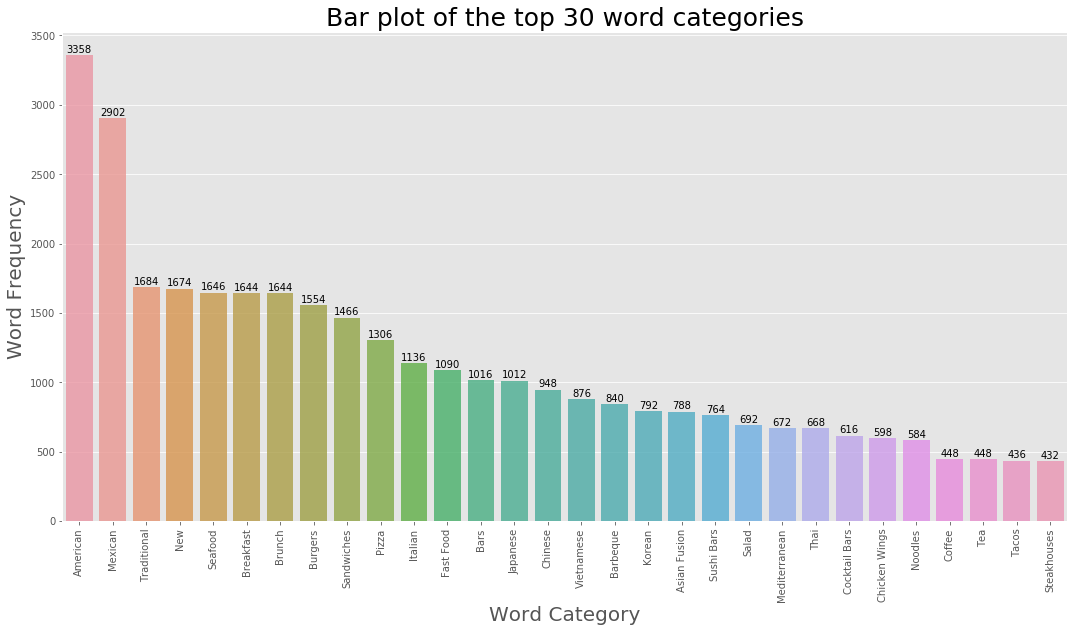

In [32]:
# Frequency Plot
catfre_df = pd.DataFrame(cat_frequency.items(), columns=['Word_Category', 'Frequency'])
# sort the df by word frequency 
catfre_df = catfre_df.sort_values('Frequency', ascending=False)
tot_cat = catfre_df.Word_Category.value_counts()
print(f"There are {len(tot_cat)} different word categories to describe restaurants in Yelp")

top_cat = catfre_df.Word_Category.iloc[0:30]
top_fre = catfre_df.Frequency.iloc[0:30]
plt.figure(figsize=(18, 9))
ax = sns.barplot(top_cat.values, top_fre.values, alpha=0.8)
plt.title("Bar plot of the top 30 word categories", fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.ylabel('Word Frequency', fontsize=20)
plt.xlabel('Word Category', fontsize=20)

# adding the text labels
rects = ax.patches
labels = top_fre.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

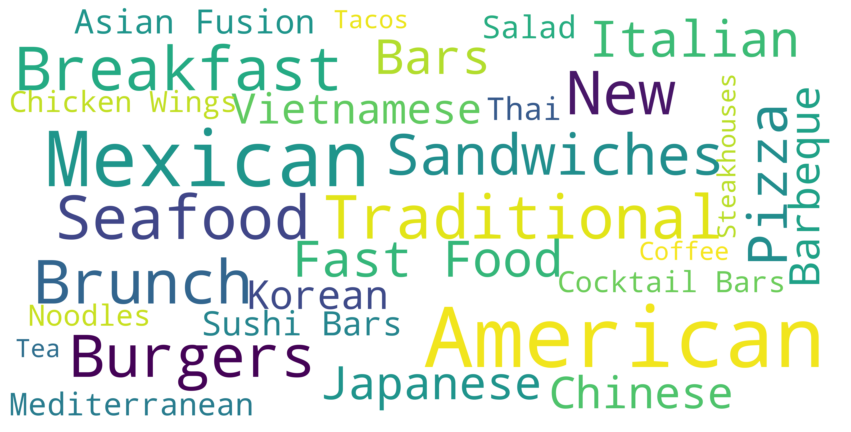

In [35]:
# word cloud plot
cats_txt_list = yelp_clean_df['Category'].to_string()
make_word_cloud(cats_txt_list, cat_frequency)

**Observations and explanation:**

### Part II: Restaurants ratings distribution analysis 

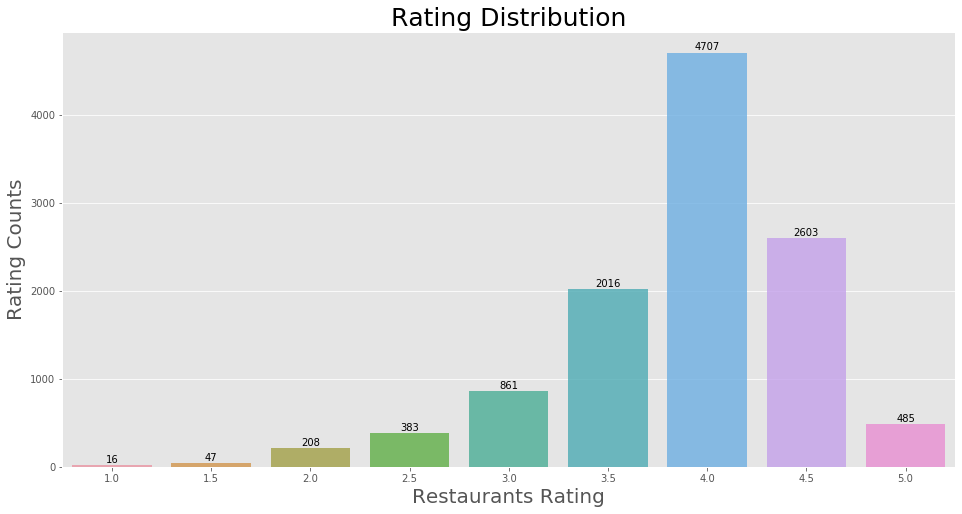

In [36]:
x_axis = yelp_clean_df['Rating'].value_counts()
x_axis.pop("Unknown")
x_axis = x_axis.sort_index()
plt.figure(figsize=(16, 8))
ax = sns.barplot(x_axis.index, x_axis.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=25)
plt.xlabel("Restaurants Rating", fontsize=20)
plt.ylabel("Rating Counts", fontsize=20)

# adding the text labels
rects = ax.patches
labels = x_axis.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

### Part III: Restaurants reviews distribution analysis based on cities 

In [37]:
reviews_df = yelp_clean_df[yelp_clean_df['Reviews'] != "Unknown"]
reviews_df['Reviews'] = reviews_df['Reviews'].apply(int)

In [38]:
# sort the df by reviews frequency 
reviews_df = reviews_df.sort_values('Reviews', ascending=False)

# extract data 
v = reviews_df['Name'].values.tolist()[0:25]
d = reviews_df['Reviews'].values.tolist()[0:25]

# set up colors
color_series = ['#FAE927','#E9E416','#C9DA36','#9ECB3C','#6DBC49',
                '#37B44E','#3DBA78','#14ADCF','#209AC9','#1E91CA',
                '#2C6BA0','#2B55A1','#2D3D8E','#44388E','#7D3990',
                '#A63F98','#C31C88','#D52178','#D5225B','#D02C2A',
                '#D44C2D','#F57A34','#FA8F2F','#D99D21','#CF7B25']

In [39]:
# pie plot instance 
pie1 = Pie(init_opts=opts.InitOpts(width='1000px', height='500px'))

# set colors
pie1.set_colors(color_series)

# import data 
pie1.add("", [list(z) for z in zip(v, d)],
        radius=["30%", "135%"],
        center=["50%", "65%"],
        rosetype="area")

# figure configurations
pie1.set_global_opts(title_opts=opts.TitleOpts(title='Top 25 restaurants with most reviews'),
                     legend_opts=opts.LegendOpts(is_show=False),
                     toolbox_opts=opts.ToolboxOpts())

pie1.set_series_opts(label_opts=opts.LabelOpts(is_show=True, position="inside", font_size=12,
                                               formatter="{b}:{c}", font_style="italic",
                                               font_weight="bold"))
pie1.render_notebook()

### Part IV: Restaurants geo-spatial analysis 

In [40]:
def get_ZIP(item):
    zip_code = item.split(',')[-1]
    if re.search(r'\d{5}', zip_code):
        return zip_code
    else:
        return "Unknown"

In [41]:
yelp_clean_df['ZIP'] = yelp_clean_df.Address.apply(get_ZIP)
yelp_clean_df['ZIP'].value_counts()["Unknown"]

12

In [42]:
yelp_clean_df.sample(3)

,index,Name,Address,Category,Price,Rating,Reviews,Mon,Tue,Wed,...,Vegetarian_Options,Accepts_Credit_Cards,Accepts_Apple_Pay,Accepts_Google_Pay,Take_out,street,lot,garage,valet,ZIP
8336,8483,Antojitos Romelia,"2105 Edison Hwy,Bakersfield,CA,93305",Unknown,Unknown,4.0,2,Unknown,Unknown,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,0,0,93305
1179,1179,Chuy's Taco Shop,"6663 El Cajon Blvd,Ste G,San Diego,CA,92115",Mexican,Under $10,4.5,596,"[[7.5, 22.0]]","[[7.5, 22.0]]","[[7.5, 22.0]]",...,Unknown,Yes,No,Unknown,Yes,1,1,1,0,92115
8249,8396,Wienerschnitzel,"2931 Niles St,Bakersfield,CA,93306","Hot Dogs,Fast Food,Sandwiches",Under $10,4.0,4,"[[9.0, 12.0]]","[[9.0, 12.0]]","[[9.0, 12.0]]",...,Unknown,Yes,Unknown,Unknown,Yes,0,0,0,0,93306


### Part: 